# Technical Fantasy Footall Analysis

This is my jupiter notebook with a fantasy football analysis of week to week data for nfl players, resulting in a 0-100 weekly player rating at the end of the analysis.

# How to run:
Simply select run all and view the outputs of each individual cell or run each cell individually in sequential order as the imports from the first few cells are used throughout.

# Loading and profiling the data:
This is done to give a quick overview of the csv file and the different data within; listing traits such as NaN values, unique values and data types.

In [14]:
import numpy as np
import pandas as pd

# Loading in the data
df = pd.read_csv("weekly_ss_scaled.csv")

# Profile the data
def data_profile(df):
    profile = pd.DataFrame({
        'dtype': df.dtypes,
        'NaN%': df.isna().mean() * 100,
        'unique_values': [df[col].nunique() for col in df.columns]
    })
    return profile

# Set pandas to show all rows
#pd.set_option('display.max_rows', None)

profile = data_profile(df)
print(profile)

                                       dtype  NaN%  unique_values
Unnamed: 0                             int64   0.0           7109
title                                 object   0.0            268
event_id                              object   0.0            268
player_name                           object   0.0            611
team_abbreviation                     object   0.0             32
...                                      ...   ...            ...
team_receiving_td_share_4th_quarter  float64   0.0              5
team_target_share_3rd_down           float64   0.0             50
team_rushing_share_3rd_down          float64   0.0             25
team_rushing_td_share_3rd_down       float64   0.0              3
team_receiving_td_share_3rd_down     float64   0.0              5

[159 rows x 3 columns]


# Cleaning the data
- dropped duplicate rows
- coerced oject types that needed to be treated as numerics into numerics
- capilitized team codes
- stripped the index column (not necessary in this analyis)
- converted empty values (--) to NaN values

Lastly I ran a profile of the data frame again to make sure that the data was properly cleaned.

In [15]:
def clean_data(df):
    """
    Clean the data based on the objectives above

    parameters:
    -----------
    df : pandas.DataFrame
        DataFrame to clean

    Returns:
    --------
    pandas.DataFrame
        Cleaned DataFrame
    """
    df_clean = df.copy()

    if 'Unnamed: 0' in df_clean.columns:
        df_clean = df_clean.drop('Unnamed: 0', axis=1)
    
    df_clean = df_clean.drop_duplicates()

    if 'event_id' in df_clean.columns:
        df_clean['event_id'] = df_clean['event_id'].str.upper()

    df_clean = df_clean.replace('--', np.nan)

    # logic to drop rows that have all 0 numeric values
    numeric_cols = df_clean.select_dtypes(include=['number']).columns

    if len(numeric_cols) > 0:
        all_numeric_are_zero = (df_clean[numeric_cols] == 0).all(axis=1)
        df_clean = df_clean[~all_numeric_are_zero]

    # logic to drop duplicate columns with different names
    df_transposed = df_clean.T
    is_duplicate_column = df_transposed.duplicated(keep='first')
    columns_to_drop = df_transposed[is_duplicate_column].index.tolist()

    df_clean = df_clean.drop(columns=columns_to_drop)

    # dropping irrelevant columns that will not be used
    prefix1 = 'pre_snap_alignment_'
    prefix2 = 'rushing_direction_'
    prefix3 = 'route_type_'
    prefix4 = 'separation_'
    prefix5 = 'pressure_type_'
    irrelevant_columns = [col for col in df_clean.columns if 
                          col.startswith(prefix1) or col.startswith(prefix2) or col.startswith(prefix3) or col.startswith(prefix4) or col.startswith(prefix5)]
    df_clean = df_clean.drop(columns=irrelevant_columns)

    # reset after dropping unnecessary rows and columns
    df_clean = df_clean.reset_index(drop=True)

    # logic to coerce numerics that need to be coerced
    df_result = df_clean.copy()

    object_columns = df_clean.select_dtypes(include=['object']).columns

    for col in object_columns:
        sample = df_clean[col].dropna()

        if len(sample) == 0:
            continue 
        
        numeric_count = 0
        total_count = len(sample)

        for val in sample:
            test_val = str(val).replace(',', '').replace('%', '').strip()

            if test_val.replace('.', '', 1).replace('-', '', 1).isdigit():
                numeric_count += 1

        numeric_percentage = (numeric_count / total_count) * 100

        if numeric_percentage > 95:
            try:
                original_nan_count = df[col].isna().sum()
                df_result[col] = pd.to_numeric(df_clean[col], errors='coerce')
                new_nan_count = df_result[col].isna().sum()

                if new_nan_count - original_nan_count > 0.1 * len(df_clean):
                    df_result[col] = df_clean[col]
            except:
                pass

    df_clean = df_result
        
    return df_clean

df_clean = clean_data(df)

clean_profile = data_profile(df_clean)
print(clean_profile)

                                       dtype  NaN%  unique_values
title                                 object   0.0            268
event_id                              object   0.0            268
player_name                           object   0.0            604
team_abbreviation                     object   0.0             32
is_motion                              int64   0.0             27
...                                      ...   ...            ...
team_receiving_td_share_4th_quarter  float64   0.0              5
team_target_share_3rd_down           float64   0.0             50
team_rushing_share_3rd_down          float64   0.0             25
team_rushing_td_share_3rd_down       float64   0.0              3
team_receiving_td_share_3rd_down     float64   0.0              5

[107 rows x 3 columns]


# Util methods used for my analysis and commentary:

In [16]:
def get_player_stats(df, player_name, stat_column=None):
    """
    Retrieve statistics for a specific player.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The NFL player stats DataFrame
    player_name : str
        Name of the player to search for (case-insensitive partial match)
    stat_column : str or list, optional
        Specific stat column(s) to return. If None, returns all columns for said player.
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the player's statistics
    """
    player_mask = df['player_name'].str.contains(player_name, case=False)
    player_data = df[player_mask]

    if len(player_data) == 0:
        print(f"No player found matching '{player_name}'")
        #show closest matches as a suggestion
        all_players = df['player_name'].unique()

        closest_matches = [p for p in all_players if player_name.lower() in p.lower()]

        if closest_matches:
            print(f"Did you mean one of these players? {', '.join(closest_matches[:5])}")
        return None
    
    #Logic for retrieving a specific stat
    if stat_column:
        if isinstance(stat_column, str):
            if stat_column in player_data.columns:
                return player_data[['player_name', 'title', stat_column]]
            
            else:
                print(f"Column '{stat_column}' not found. Available columns: {', '.join(player_data.columns[:10])}...")
                return None
            
        elif isinstance(stat_column, list):
            columns_to_return = ['player_name', 'title', 'team_abbreviation', 'position'] + [col for col in stat_column]
            return player_data[columns_to_return]

    return player_data

def get_max_stats(df, stats, positions=None):
    """
    Find the player(s) with the maximum value for each statistic and position combination.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing player statistics
    stats : str or list
        Either a single statistic (string) or a list of statistics
    positions : str or list, optional
        Either a single position (string) or a list of positions.
        If None, uses all positions in the dataset.
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame showing the player with max stat value for each position and statistic
    """
    filtered_df = df.copy()
    
    if 'position' not in filtered_df.columns:
        print("Error: Position column not found in the dataset")
        return None
        
    # Process positions parameter
    if positions is None:
        position_list = sorted(filtered_df['position'].unique())

    elif isinstance(positions, str):
        position_list = [positions]

    else:
        position_list = list(positions)
    
    # Process stats parameter
    if isinstance(stats, str):
        stat_list = [stats]

    else:
        stat_list = list(stats)
    
    missing_stats = [stat for stat in stat_list if stat not in filtered_df.columns]
    if missing_stats:
        print(f"Warning: These statistics were not found in the dataset: {', '.join(missing_stats)}")

        stat_list = [stat for stat in stat_list if stat in filtered_df.columns]
        
        if not stat_list:
            print("Error: No valid statistics to process")
            return None
    
    all_results = pd.DataFrame()
    
    # Process each position and statistic combination
    for pos in position_list:
        pos_data = filtered_df[filtered_df['position'] == pos]
            
        for stat in stat_list:
            max_value = pos_data[stat].max()
            
            # Skip if all values are NaN
            if pd.isna(max_value):
                continue
            
            # Find all players who achieved this maximum
            max_players = pos_data[pos_data[stat] == max_value]
            
            all_results = pd.concat([all_results, max_players])

    columns_to_return = ['player_name', 'title', 'team_abbreviation', 'position'] + [col for col in stat_list]
    return all_results[columns_to_return]


# Initial data vizualizations:
# vizualization #1: Boxplot of rushing yards by position

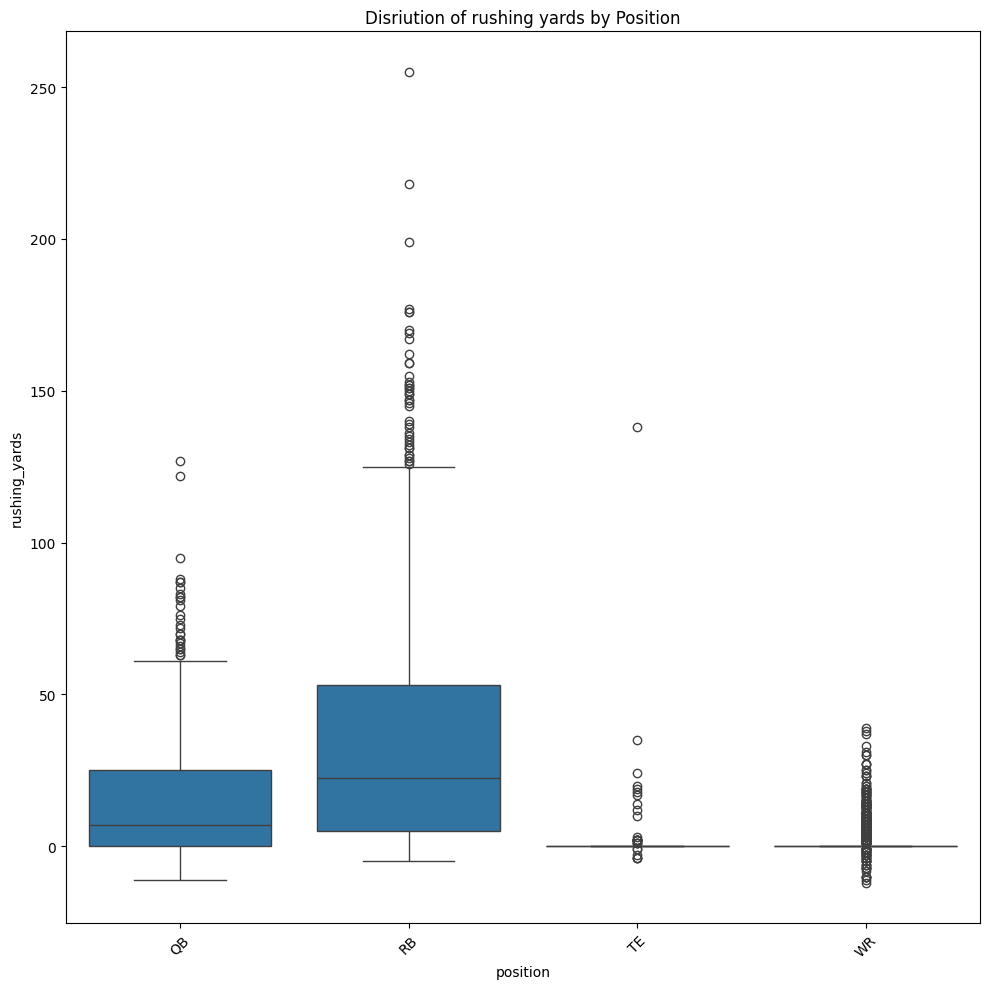

,player_name,title,team_abbreviation,position,rushing_yards
2677,Jayden Daniels,ATL @ WAS,WAS,QB,127
1035,Taysom Hill,CLE @ NO,NO,TE,138
3550,Saquon Barkley,PHI @ LA,PHI,RB,255


,player_name,title,team_abbreviation,position,rushing_yards
5910,Lamar Jackson,BAL @ KC,BAL,QB,122


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

plt.figure(figsize=(10,10))
sns.boxplot(x='position', y='rushing_yards', data=df_clean)
plt.title('Disriution of rushing yards by Position')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
display(get_max_stats(df_clean, 'rushing_yards', ['QB', 'TE', 'RB']))
lamar_df = get_player_stats(df_clean, 'lamar jackson',['rushing_yards'])
lamar_max_idx = lamar_df['rushing_yards'].idxmax()
lamar_max_rushing = lamar_df.loc[[lamar_max_idx]]
display(lamar_max_rushing)


# Commentary: This boxplot shows how rushing yards vary across different positions.
- As expected, RB's (running backs) have the highest median and range of rushing yards
- QB's (quarter backs) show occasional high rushing values from scrambles and set QB draws (think players like Lamar Jackson, Jayden Daniels, Jalen Hurts, Kyler Murray and Josh Allen)
- WR's and TE's typically have much lower rushing yards from occasional plays like WR sweeps and wildcat TE plays
- Notable positional outliers include (note the dataframes showing these outliers):
    - Tight-End: Taysom Hill (true story he actually single-handedly won me that week in fantasy lol)
    - Quarter-Backs: Lamar Jackson and Jayden Daniels (these guys are basically RB's playing the QB position, cheat code for 4-point per passing touchdown leagues due to their rushing upside)
    - Running-Back: Saquon Barkley (should be considered the consensus #1 pick in 2025 drafts, especially in half-ppr leagues)
# Vizualization #2 Heat-map of correlation among yards after catch, yards after contact and rushing yards

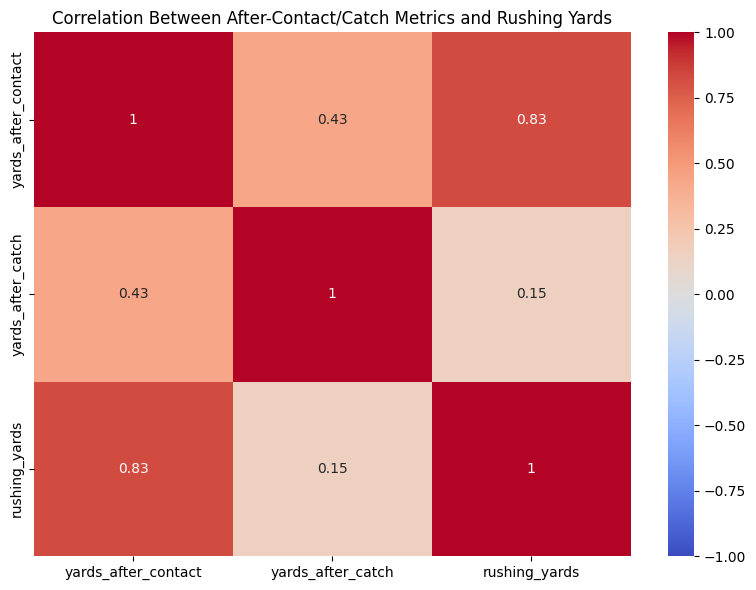

,player_name,title,team_abbreviation,position,yards_after_contact,yards_after_catch
6371,Ja'Marr Chase,CIN @ BAL,CIN,WR,8,103
4944,Ja'Marr Chase,BAL @ CIN,CIN,WR,70,97


,player_name,title,team_abbreviation,position,rushing_yards,yards_after_contact
3046,Derrick Henry,BUF @ BAL,BAL,RB,199,54
3848,Derrick Henry,BAL @ DAL,BAL,RB,151,130


,player_name,title,team_abbreviation,position,rushing_yards,yards_after_contact
4957,Alvin Kamara,NO @ CAR,NO,RB,155,108


In [18]:
correlation_cols = ['yards_after_contact', 'yards_after_catch', 'rushing_yards']
corr_matrix = df_clean[correlation_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between After-Contact/Catch Metrics and Rushing Yards')
plt.tight_layout()
plt.show()
alvin_stats_df = get_player_stats(df_clean,'alvin kamara', ['rushing_yards', 'yards_after_contact'])
alvin_max_rushing = alvin_stats_df['rushing_yards'].idxmax()
alvin_stats_df = alvin_stats_df.loc[[alvin_max_rushing]]
derrick_stats_df = get_player_stats(df_clean, 'derrick henry', ['rushing_yards', 'yards_after_contact'])
derrick_max_rushing = derrick_stats_df['rushing_yards'].idxmax()
derrick_max_yards_after_contact = derrick_stats_df['yards_after_contact'].idxmax()
derrick_stats_df = pd.concat([derrick_stats_df.loc[[derrick_max_rushing]], derrick_stats_df.loc[[derrick_max_yards_after_contact]]])
jamarr_stats_df = get_player_stats(df_clean, "Ja'marr chase", ['yards_after_contact','yards_after_catch'])
jamarr_max_yards_after_catch = jamarr_stats_df['yards_after_catch'].idxmax()
jamarr_max_yards_after_contact = jamarr_stats_df['yards_after_contact'].idxmax()
jamarr_stats_df = pd.concat([jamarr_stats_df.loc[[jamarr_max_yards_after_catch]], jamarr_stats_df.loc[[jamarr_max_yards_after_contact]]])
display(jamarr_stats_df)
display(derrick_stats_df)
display(alvin_stats_df)

# Comentary: This heatmap reveals the correlation between yards after contact, yards after catch and rushing yards.
- The strong positive correlation between rushing yards and yards after contact (0.83) suggests that players who excel at breaking tackles contribute significantly to rushing production (think running backs that excel at running between the tackles like Derrick Henry)
- The medium correlation between yards after catch and yards after contact shows a weaker, but still present relationship, illustrating how players that produce yards after the catch also typically produce yards after contact (this is likely due to the fact that receivers often have to break tackles after a contested catch in order to produce yards after the catch e.g., Ja'Marr Chase)
- Lastly the weak correlation between rushing yards and yards after the catch suggests that players who produce yards after the catch don't typically contribute to rushing production (This correlation is most likely solely populated by passing backs such as: Jahmyr Gibbs, Alvin Kamara, Saquon Barkley and Bijan Robinson who produce significant yards after the catch on plays like screen passes and checkdowns)
# Method for 0-100 Player Matchup Rating

In [19]:
def create_features(df):
    # Make a copy to work with
    df_features = df.copy()
    
    # Derive completion percentage
    if 'pass_attempt' in df_features.columns and 'pass_completion' in df_features.columns:
        df_features['completion_pct'] = df_features['pass_completion'] / df_features['pass_attempt']
        
    # Derive yards per rush
    if 'rushing_attempt' in df_features.columns and 'rushing_yards' in df_features.columns:
        df_features['yards_per_rush'] = df_features['rushing_yards'] / df_features['rushing_attempt']
    
    # Derive catch rate
    if 'receiving_targets' in df_features.columns and 'reception' in df_features.columns:
        df_features['catch_rate'] = df_features['reception'] / df_features['receiving_targets']
    
    # Normalize yards after contact per rushing attempt
    if 'yards_after_contact' in df_features.columns and 'rushing_attempt' in df_features.columns:
        df_features['yards_after_contact_per_attempt'] = df_features['yards_after_contact'] / df_features['rushing_attempt']
    
    # Normalize yards after catch per reception
    if 'yards_after_catch' in df_features.columns and 'reception' in df_features.columns:
        df_features['yards_after_catch_per_reception'] = df_features['yards_after_catch'] / df_features['reception']
    
    # Handle NaN values resulting from division by zero
    numeric_cols = df_features.select_dtypes(include=['float64', 'int64']).columns
    df_features[numeric_cols] = df_features[numeric_cols].fillna(0)
    
    return df_features

df_with_features = create_features(df_clean)

def normalize_by_position(df, feature_cols):
    """Normalize features within each position group."""
    df_norm = df.copy()
    
    for col in feature_cols:
        # Method 1: Percentile Ranking (0-1 scale)
        for pos in df_norm['position'].unique():
            pos_mask = df_norm['position'] == pos
            if pos_mask.sum() > 0:  # Only process if position exists
                df_norm.loc[pos_mask, f'{col}_pct'] = df_norm.loc[pos_mask, col].rank(pct=True)
        
        # Method 2: Z-score with clipping
        for pos in df_norm['position'].unique():
            pos_mask = df_norm['position'] == pos
            if pos_mask.sum() > 0:
                mean = df_norm.loc[pos_mask, col].mean()
                std = df_norm.loc[pos_mask, col].std()
                
                if std > 0:  # Avoid division by zero
                    z_scores = (df_norm.loc[pos_mask, col] - mean) / std
                    df_norm.loc[pos_mask, f'{col}_z'] = np.clip(z_scores, -3, 3)
                else:
                    df_norm.loc[pos_mask, f'{col}_z'] = 0
                    
    return df_norm

# List of features to normalize
norm_features = [
    'completion_pct', 'yards_per_rush', 'catch_rate',
    'yards_after_contact_per_attempt', 'yards_after_catch_per_reception',
    'team_target_share', 'team_rushing_share'
]

df_normalized = normalize_by_position(df_with_features, norm_features)

def score(df: pd.DataFrame):
    """
    Return a 0-100 score for each row of a cleaned weekly-stats DataFrame.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Cleaned weekly player stats DataFrame
        
    Returns:
    --------
    pd.Series
        A series of scores from 0-100 for each player-week
    """
    # Select normalized features for scoring (using percentile method)
    score_features = [
        'completion_pct_pct',         # Weight: 0.15 (QB passing efficiency)
        'yards_per_rush_pct',         # Weight: 0.15 (RB/QB rushing efficiency)
        'catch_rate_pct',             # Weight: 0.15 (WR/TE receiving efficiency)
        'team_target_share_pct',      # Weight: 0.15 (WR/TE usage)
        'team_rushing_share_pct',     # Weight: 0.15 (RB/QB rushing usage)
        'yards_after_contact_per_attempt_pct',  # Weight: 0.10 (RB power)
        'yards_after_catch_per_reception_pct',  # Weight: 0.10 (WR/TE YAC)
        'receiving_touchdown_redzone_pct'  # Weight: 0.05 (Situational impact)
    ]
    
    # Define weights (should sum to 1)
    weights = {
        'completion_pct_pct': 0.15,
        'yards_per_rush_pct': 0.15,
        'catch_rate_pct': 0.15,
        'team_target_share_pct': 0.15,
        'team_rushing_share_pct': 0.15,
        'yards_after_contact_per_attempt_pct': 0.10,
        'yards_after_catch_per_reception_pct': 0.10,
        'receiving_touchdown_redzone_pct': 0.05
    }
    
    # Calculate weighted score
    raw_score = pd.Series(0, index=df.index)
    for feature, weight in weights.items():
        if feature in df.columns:
            raw_score += df[feature] * weight
    
    # Rescale to 0-100
    min_score = raw_score.min()
    max_score = raw_score.max()
    
    if max_score > min_score:
        final_score = 100 * (raw_score - min_score) / (max_score - min_score)
    else:
        final_score = raw_score * 0  # All scores would be identical
    
    return final_score

# Apply the scoring function
df_normalized['player_rating'] = score(df_normalized)

df_scores = df_normalized[['title', 'player_name', 'position', 'team_abbreviation', 'player_rating']] 

df_scores = df_scores.sort_values(by='player_rating', ascending=False)

display(df_normalized)
#display(df_scores)

,title,event_id,player_name,team_abbreviation,is_motion,motion_at_snap,pre_snap_motion,rushing_attempt,rushing_touchdown,rushing_yards,...,catch_rate_z,yards_after_contact_per_attempt_pct,yards_after_contact_per_attempt_z,yards_after_catch_per_reception_pct,yards_after_catch_per_reception_z,team_target_share_pct,team_target_share_z,team_rushing_share_pct,team_rushing_share_z,player_rating
0,BAL @ TB,023E284C-6932-4EAE-A99E-7561E950DAAB,Baker Mayfield,TB,0,0,0,5,0,22,...,-0.076250,0.850217,0.439136,0.498553,-0.058031,0.496382,-0.091340,0.690304,0.400741,60.857492
1,BAL @ TB,023E284C-6932-4EAE-A99E-7561E950DAAB,Bucky Irving,TB,1,0,1,9,1,23,...,1.032398,0.347030,0.000000,0.953039,1.810522,0.604282,0.040763,0.568370,0.011561,58.343872
2,BAL @ TB,023E284C-6932-4EAE-A99E-7561E950DAAB,Cade Otton,TB,14,7,7,0,0,0,...,0.772664,0.777846,0.000000,0.742962,0.428057,0.914321,1.661226,0.490820,-0.105747,67.776013
3,BAL @ TB,023E284C-6932-4EAE-A99E-7561E950DAAB,Charlie Kolar,BAL,0,0,0,0,0,0,...,1.236741,0.270196,0.000000,0.629437,0.037937,0.537332,-0.273532,0.490820,-0.105747,53.758133
4,BAL @ TB,023E284C-6932-4EAE-A99E-7561E950DAAB,Chris Godwin,TB,3,1,2,0,0,0,...,0.771044,0.773910,0.000000,0.679036,0.115888,0.743305,0.644665,0.440513,-0.309202,62.129069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6382,CIN @ BAL,FF342D6D-BED1-4A7C-9B9D-6795D2E26CE9,Tanner Hudson,CIN,5,1,4,1,0,1,...,0.656645,0.550796,0.000000,0.735924,0.398048,0.810282,0.829760,0.994186,3.000000,83.834010
6383,CIN @ BAL,FF342D6D-BED1-4A7C-9B9D-6795D2E26CE9,Trayveon Williams,CIN,0,0,0,0,0,0,...,-1.219285,0.056630,0.000000,0.199240,-0.854231,0.161948,-0.963674,0.062500,-1.212791,0.341750
6384,CIN @ BAL,FF342D6D-BED1-4A7C-9B9D-6795D2E26CE9,Trenton Irwin,CIN,1,0,1,0,0,0,...,-1.329088,0.220735,0.000000,0.188600,-0.695064,0.106350,-1.103276,0.440513,-0.309202,17.776445
6385,CIN @ BAL,FF342D6D-BED1-4A7C-9B9D-6795D2E26CE9,Tylan Wallace,BAL,6,3,3,0,0,0,...,1.371082,0.773910,0.000000,0.996557,3.000000,0.478577,-0.265721,0.440513,-0.309202,64.826356


# Validation with a volatility plot

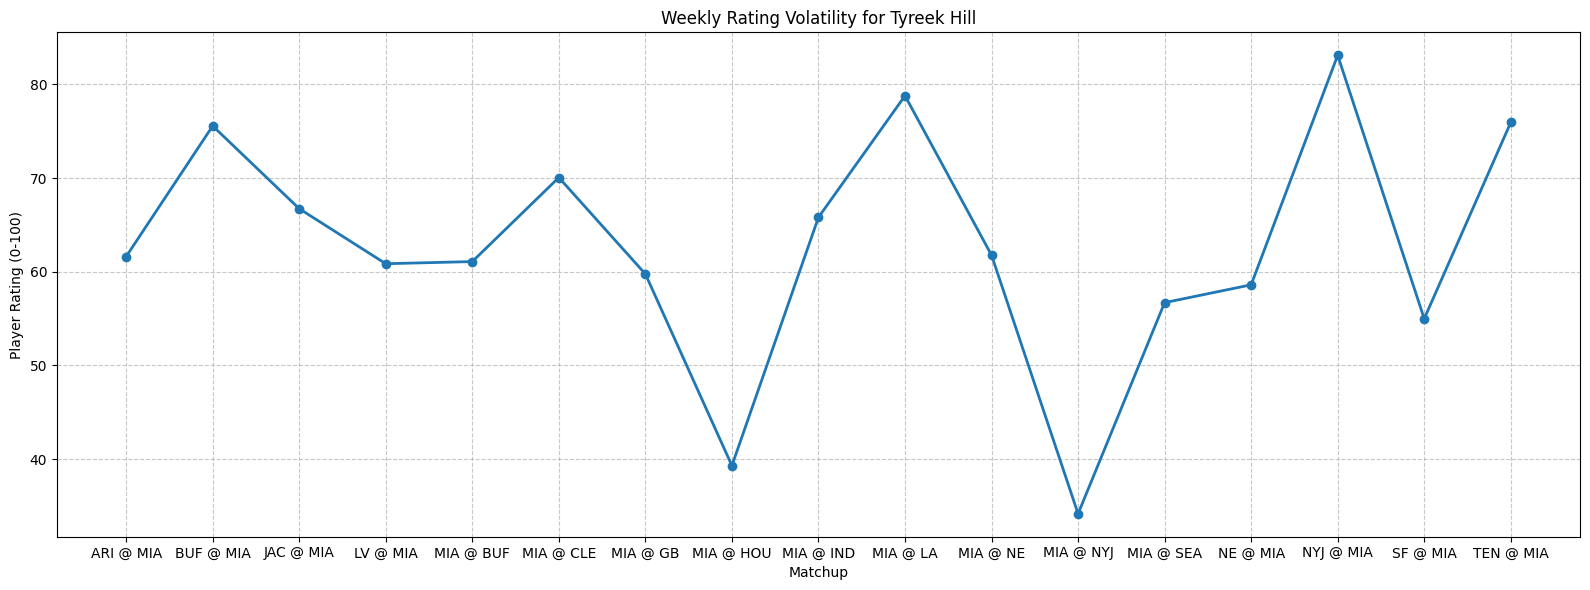

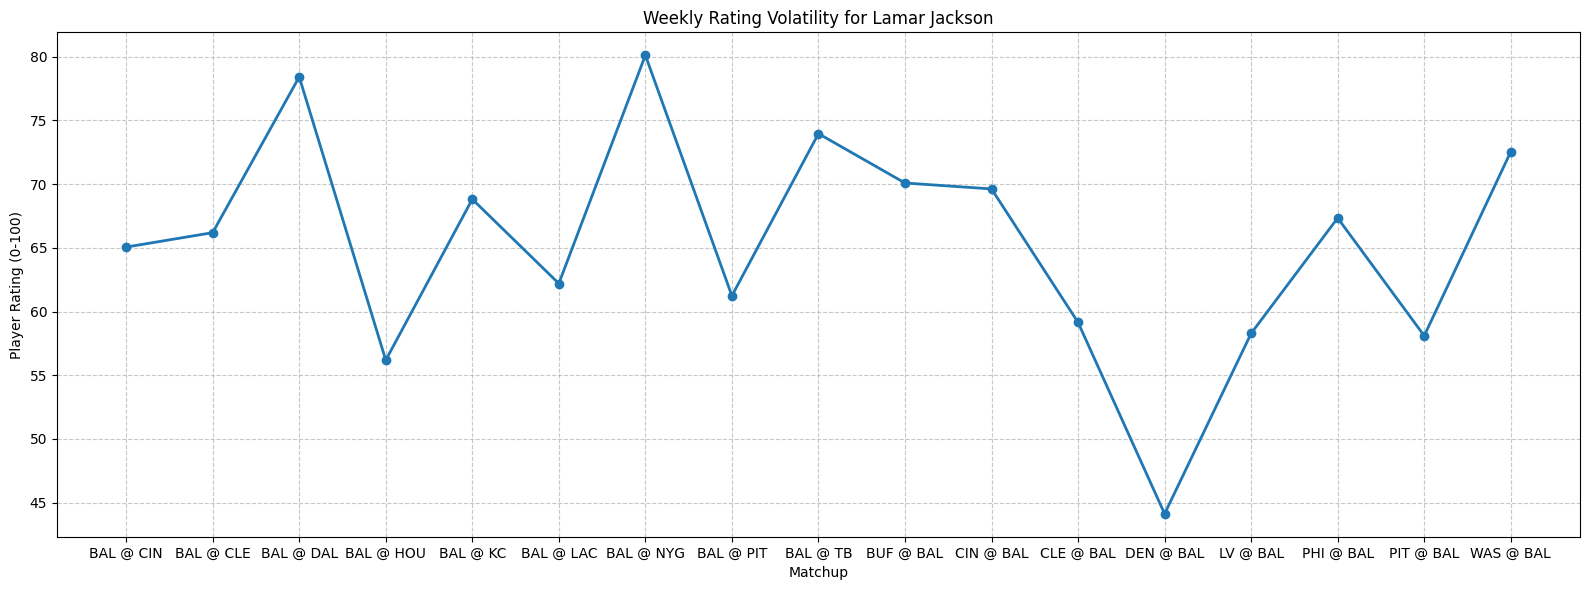

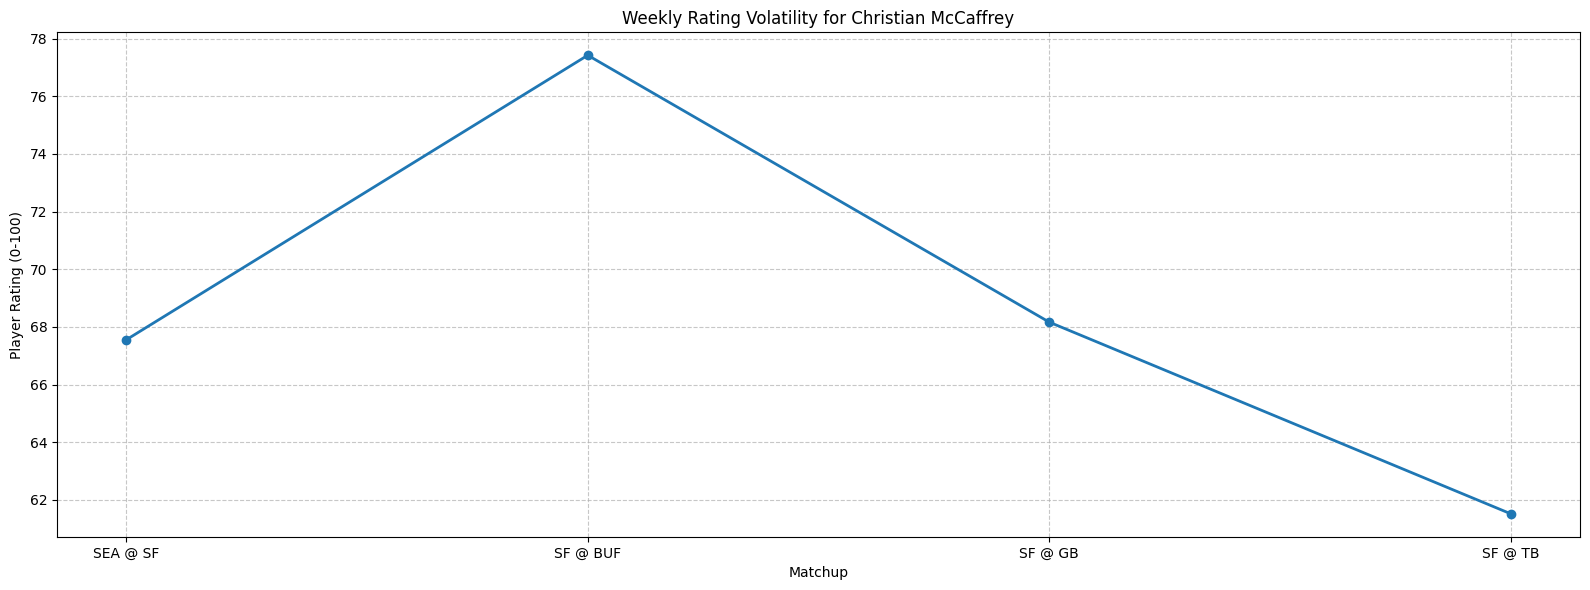

In [20]:
# Volatility plot for a specific player
def plot_player_volatility(df, player_name):
    player_data = df[df['player_name'] == player_name].sort_values('title')
    
    plt.figure(figsize=(16, 6))
    plt.plot(player_data['title'], player_data['player_rating'], 'o-', linewidth=2)
    plt.title(f'Weekly Rating Volatility for {player_name}')
    plt.xlabel('Matchup')
    plt.ylabel('Player Rating (0-100)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
plot_player_volatility(df_scores, "Tyreek Hill")
plot_player_volatility(df_scores, "Lamar Jackson")
plot_player_volatility(df_scores, 'Christian McCaffrey')